<a href="https://colab.research.google.com/github/marianavalho/ML2025/blob/main/Ass4_MN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1: Train Acc: 0.9560, Val Acc: 0.9847
Epoch 2: Train Acc: 0.9805, Val Acc: 0.9848
Epoch 3: Train Acc: 0.9838, Val Acc: 0.9876
Epoch 4: Train Acc: 0.9907, Val Acc: 0.9934
Epoch 5: Train Acc: 0.9920, Val Acc: 0.9937
Epoch 6: Train Acc: 0.9927, Val Acc: 0.9937
Epoch 7: Train Acc: 0.9938, Val Acc: 0.9937
Epoch 8: Train Acc: 0.9937, Val Acc: 0.9937
Epoch 9: Train Acc: 0.9940, Val Acc: 0.9938
Epoch 10: Train Acc: 0.9939, Val Acc: 0.9938


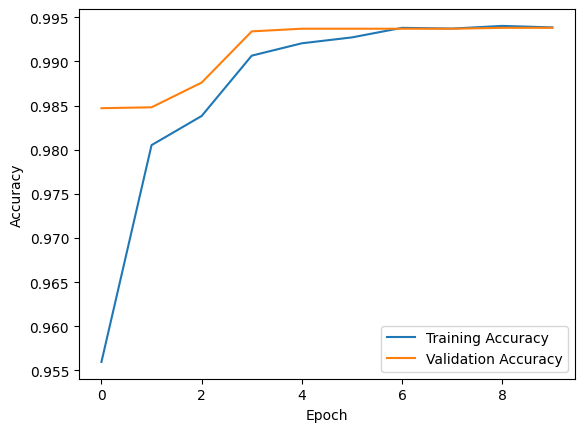

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enhanced Model Architecture
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Add this
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Add this
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # Add bn1
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))  # Add bn2
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training Setup
def train_model():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_data = datasets.MNIST("./data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST("./data", train=False, transform=transform)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64)

    model = EnhancedMNISTCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    best_acc = 0.0
    history = {"train": [], "val": []}

    for epoch in range(10):
        model.train()
        train_loss, train_correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        scheduler.step()
        train_acc = train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        val_acc = val_correct / len(test_loader.dataset)

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "mnist_cnn_model.pt")

        history["train"].append(train_acc)
        history["val"].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Plot results
    plt.plot(history["train"], label="Training Accuracy")
    plt.plot(history["val"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    train_model()